In [3]:
import sys
sys.path.append('..')

In [4]:
import matplotlib.pyplot as plt
import random
import numpy as np
from agents.elevator_expert import ElevatorExpertPolicyAgent
from agents.random_agent import RandomAgent
from agents.llmzero import LLMTransitionModel, LLMRewardModel
from environments.ElevatorEnvironment import ElevatorEnvironment

import os
import dotenv
dotenv.load_dotenv()

env = ElevatorEnvironment()

llmzero_reward_model = LLMRewardModel(
    debug=False,
    load_prompt_buffer_path=None,
    env_params={
        "system_prompt_path": "../prompts/prompt_elevator_reward.txt",
        "extract_reward_regex": r"TOTAL_REWARD_FINAL = (-?\d+\.\d+)", # only use the first match, same line
        "extract_reward_regex_fallback": [r"TOTAL_REWARD_FINAL = (-?\d+\.\d+)"],
    },
)

/opt/miniconda3/envs/llmzero/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


/opt/miniconda3/envs/llmzero/lib/python3.11/site-packages/pyRDDLGym/Examples /opt/miniconda3/envs/llmzero/lib/python3.11/site-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
Traffic -> BLX/QTM traffic model.
Reservoir_discrete -> Discrete version of management of the water level in interconnected reservoirs.
Reservoir_continuous -> Continuous action version of management of the water level in interconnected reservoirs.
RaceCar -> A simple continuous MDP for the racecar problem.
RecSim -> A problem of recommendation systems, with consumers and providers.
HVAC -> Multi-zone and multi-heater HVAC control problem
PropDBN -> Simple propositional DBN.
Wildfire -> A boolean version of the wildfire fighting domain.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous -> A simple continuous state-action MD

/opt/miniconda3/envs/llmzero/lib/python3.11/site-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


In [5]:
SEED = 117
np.random.seed(SEED)
random.seed(SEED)

In [6]:
random_agent = RandomAgent(env, seed=SEED)
expert_agent = ElevatorExpertPolicyAgent()

# random agent
state, _ = env.reset(SEED)
done = False

random_agent_trajectory = []

while not done:
    action = random_agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    random_agent_trajectory.append((state, action, reward, next_state, done))
    state = next_state
    
# expert agent
state, _ = env.reset(SEED + 1)  # use a different seed for the expert agent
done = False

expert_agent_trajectory = []

while not done:
    action = expert_agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    expert_agent_trajectory.append((state, action, reward, next_state, done))
    state = next_state

In [7]:
trajectories_combined = random_agent_trajectory + expert_agent_trajectory

In [8]:
llmzero_reward_model.llm_model

'mistral-large-2407'

In [9]:
import tqdm


def test_reward_model(model: LLMRewardModel, trajectories):
    gt_rewards = []
    predicted_rewards = []
    squared_errors = []
    status_list = []

    pbar = tqdm.tqdm(trajectories)

    for trajectory in pbar:
        state, action, reward, next_state, done = trajectory
        state_text = env.state_to_text(state)
        predicted_reward, status = model.get_reward(state_text)

        gt_rewards.append(reward)
        predicted_rewards.append(predicted_reward)
        squared_errors.append((reward - predicted_reward) ** 2 / (reward + 1.0))
        status_list.append(status)
        pbar.set_description(f"Squared error: {np.mean(squared_errors)}")
    return gt_rewards, predicted_rewards, status_list

In [10]:
gt_rewards, predicted_rewards, status_list = test_reward_model(llmzero_reward_model, trajectories_combined)

Squared error: 0.0:   3%|▎         | 13/400 [02:43<1:06:59, 10.39s/it]

Error saving prompt buffer: [Errno 2] No such file or directory: 'prompt_buffer/elevator_reward_20241110_083703.pkl'


Squared error: -0.002796397900763359: 100%|██████████| 400/400 [55:28<00:00,  8.32s/it]   


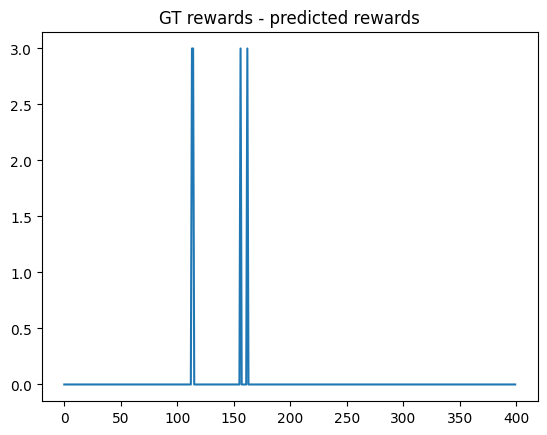

In [12]:
#enable inline plotting
%matplotlib inline

gt_rewards = np.array(gt_rewards)
predicted_rewards = np.array(predicted_rewards)

diff = gt_rewards - predicted_rewards

plt.plot(diff)
plt.title("GT rewards - predicted rewards")
plt.show()